# PST to DuckDB

Notebook to explore cleanly how to go from mbox file format to DuckDB database followed The Classes in models/models.py cleanly without different codes etc.
This has to be transformed into different function files later on.

## Imports

In [1]:
from __future__ import annotations
import mailbox
import pandas as pd
import email
import os
from email.header import decode_header
import datetime
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import sqlite3
import html
import sys
import argparse


import duckdb

import json
import uuid
from typing import List, Dict, Any, Optional, Tuple


### Importing classes

In [2]:
from models.models import EmailAddress, MailingList, Organisation, Position, Entity, Attachment, ReceiverEmail, SenderEmail

# Import Pydantic elements
from pydantic import BaseModel, Field

## Functions

### Mbox/Text Processing

In [3]:
def parse_email_address(address_str):
    """Parse a string containing email addresses into a list of Entity objects with better error handling"""
    if not address_str:
        return []

    entities = []
    # Simple regex to extract name and email from patterns like "Name <email@example.com>"
    email_pattern = re.compile(r'(.*?)\s*<([^>]+)>|([^,\s]+@[^,\s]+)')

    try:
        # Split by commas, but handle potential nested commas in quotes
        addresses = []
        in_quotes = False
        current_address = ""

        for char in address_str:
            if char == '"':
                in_quotes = not in_quotes
                current_address += char
            elif char == ',' and not in_quotes:
                addresses.append(current_address.strip())
                current_address = ""
            else:
                current_address += char

        # Add the last address if there is one
        if current_address.strip():
            addresses.append(current_address.strip())

        # If no addresses were found, try the whole string
        if not addresses:
            addresses = [address_str]

        for addr in addresses:
            addr = addr.strip()
            if not addr:
                continue

            try:
                match = email_pattern.search(addr)
                if match:
                    if match.group(2):  # Format: "Name <email@example.com>"
                        name = match.group(1).strip().strip('"')
                        email_addr = match.group(2).strip()
                    else:  # Format: "email@example.com"
                        email_addr = match.group(3).strip()
                        name = email_addr  # Use email as name if no name is provided

                    # Validate email format to a minimum degree
                    if '@' in email_addr:
                        # Create Entity with EmailAddress
                        try:
                            email_obj = EmailAddress(email=email_addr)
                            entity = Entity(
                                name=name,
                                email=email_obj,
                                is_physical_person=True  # Assuming default
                            )
                            entities.append(entity)
                        except Exception as e:
                            print(f"Error creating Entity for email {email_addr}: {e}")
                else:
                    # Try a more forgiving approach if the regex didn't match
                    parts = addr.split('@')
                    if len(parts) == 2 and '.' in parts[1]:
                        # Looks like a valid email
                        email_addr = addr.strip()
                        try:
                            email_obj = EmailAddress(email=email_addr)
                            entity = Entity(
                                name=email_addr,  # Use email as name
                                email=email_obj,
                                is_physical_person=True
                            )
                            entities.append(entity)
                        except Exception as e:
                            print(f"Error creating Entity for fallback email {email_addr}: {e}")
            except Exception as e:
                print(f"Error parsing address '{addr}': {e}")
    except Exception as e:
        print(f"Error parsing addresses string '{address_str}': {e}")

    return entities

In [4]:
def decode_str(s):
    """Decode encoded email header strings"""
    if s is None:
        return ""
    try:
        decoded_parts = decode_header(s)
        return ''.join([
            part.decode(encoding or 'utf-8', errors='replace') if isinstance(part, bytes) else part
            for part, encoding in decoded_parts
        ])
    except:
        return str(s)

def extract_clean_text_from_html(html_content):
    """
    Extract clean, readable text from HTML content.

    Args:
        html_content (str): HTML content to clean

    Returns:
        str: Clean text without HTML tags
    """
    if not html_content:
        return ""

    try:
        # Remove scripts, styles, and other tags that contain content we don't want
        html_content = re.sub(r'<(script|style|head).*?>.*?</\1>', ' ', html_content, flags=re.DOTALL)

        # Replace common block elements with newlines to preserve structure
        html_content = re.sub(r'</(p|div|h\d|tr|li)>', '\n', html_content)
        html_content = re.sub(r'<br[^>]*>', '\n', html_content)

        # Replace table cells with tab separation
        html_content = re.sub(r'</td>', '\t', html_content)

        # Remove all HTML tags
        text = re.sub(r'<[^>]+>', ' ', html_content)

        # Decode HTML entities (&nbsp;, &lt;, etc.)
        text = html.unescape(text)

        # Handle literal escape sequences that appear in the text
        # Replace literal "\xad" with empty string (remove soft hyphens)
        text = text.replace('\\xad', '')
        # Replace literal "\xa0" with a space (non-breaking spaces)
        text = text.replace('\\xa0', ' ')

        # Handle actual Unicode characters too
        # Remove soft hyphens (invisible hyphens used for word breaks)
        text = text.replace('\xad', '')
        # Replace non-breaking spaces with regular spaces
        text = text.replace('\xa0', ' ')
        # Remove other problematic control characters
        text = re.sub(r'[\x00-\x08\x0b-\x0c\x0e-\x1f\x7f]', '', text)

        # Clean up other escape sequences that might appear in text
        text = text.replace('\\\\', '\\')  # Double backslash to single
        text = text.replace("\\'", "'")    # Escaped single quote
        text = text.replace('\\"', '"')    # Escaped double quote
        text = text.replace('\\n', '\n')   # Literal \n to newline
        text = text.replace('\\t', '\t')   # Literal \t to tab

        # Remove remaining literal escape sequences like \x.. that weren't handled above
        text = re.sub(r'\\x[0-9a-fA-F]{2}', '', text)

        # Clean up whitespace (multiple spaces, tabs, newlines)
        text = re.sub(r'[ \t]+', ' ', text)
        text = re.sub(r'\n{3,}', '\n\n', text)

        # Final cleanup to remove leading/trailing whitespace
        return text.strip()
    except Exception as e:
        print(f"Error processing HTML: {e}")
        return f"Error processing HTML content: {str(e)}"

In [5]:

def get_email_body(message):
    """Extract body text from email message, handling HTML correctly"""
    body_text = ""
    body_html = ""

    if message.is_multipart():
        for part in message.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition") or "")

            # Skip attachments
            if "attachment" in content_disposition:
                continue

            try:
                payload = part.get_payload(decode=True)
                if payload is None:
                    continue

                charset = part.get_content_charset() or 'utf-8'
                decoded_payload = payload.decode(charset, errors='replace')

                if content_type == "text/plain":
                    body_text += decoded_payload
                elif content_type == "text/html":
                    body_html += decoded_payload
            except:
                continue
    else:
        # Not multipart - get payload directly
        try:
            content_type = message.get_content_type()
            payload = message.get_payload(decode=True)
            if payload:
                charset = message.get_content_charset() or 'utf-8'
                decoded_payload = payload.decode(charset, errors='replace')

                if content_type == "text/plain":
                    body_text = decoded_payload
                elif content_type == "text/html":
                    body_html = decoded_payload
        except:
            pass

    # Prefer HTML content but fall back to plain text
    if body_html:
        return {
            "html": body_html,
            "text": extract_clean_text_from_html(body_html),
            "has_html": True
        }
    else:
        return {
            "html": "",
            "text": body_text,
            "has_html": False
        }

def extract_attachments_info(message):
    """Extract information about attachments with better error handling"""
    attachments = []

    if not message.is_multipart():
        return attachments

    try:
        for part in message.walk():
            try:
                content_disposition = str(part.get("Content-Disposition") or "")

                if "attachment" in content_disposition:
                    try:
                        filename = part.get_filename()
                        if filename:
                            try:
                                filename = decode_str(filename)
                            except Exception as e:
                                print(f"Error decoding attachment filename: {e}")
                                filename = "unknown_filename"
                        else:
                            filename = "unnamed_attachment"

                        content_type = part.get_content_type() or 'application/octet-stream'

                        # Get content safely
                        try:
                            content = part.get_payload(decode=True)
                            # Ensure content is bytes
                            if content is None:
                                content = b''
                            elif not isinstance(content, bytes):
                                content = str(content).encode('utf-8', errors='replace')
                        except Exception as e:
                            print(f"Error getting attachment content: {e}")
                            content = b''

                        size = len(content)

                        attachments.append({
                            "filename": filename,
                            "content_type": content_type,
                            "size": size,
                            "content": content
                        })
                    except Exception as e:
                        print(f"Error processing individual attachment: {e}")
            except Exception as e:
                print(f"Error walking email part: {e}")
    except Exception as e:
        print(f"Error in attachment extraction: {e}")

    return attachments

def extract_recipients(message):
    """Extract all recipients (To, CC, BCC) as Entity objects with better error handling"""
    to_str = decode_str(message.get('to') or "")
    cc_str = decode_str(message.get('cc') or "")
    bcc_str = decode_str(message.get('bcc') or "")
    reply_to_str = decode_str(message.get('reply-to') or "")

    # Parse with error handling
    try:
        to_entities = parse_email_address(to_str)
    except Exception as e:
        print(f"Error parsing 'to' field: {e}, value: {to_str}")
        to_entities = []

    try:
        cc_entities = parse_email_address(cc_str)
    except Exception as e:
        print(f"Error parsing 'cc' field: {e}, value: {cc_str}")
        cc_entities = []

    try:
        bcc_entities = parse_email_address(bcc_str)
    except Exception as e:
        print(f"Error parsing 'bcc' field: {e}, value: {bcc_str}")
        bcc_entities = []

    reply_to_entity = None
    try:
        reply_to_entities = parse_email_address(reply_to_str)
        if reply_to_entities and len(reply_to_entities) > 0:
            reply_to_entity = reply_to_entities[0]
    except Exception as e:
        print(f"Error parsing 'reply-to' field: {e}, value: {reply_to_str}")

    return {
        "to": to_entities,
        "cc": cc_entities,
        "bcc": bcc_entities,
        "reply_to": reply_to_entity
    }

def extract_message_data(message, folder_name):
    """Extract comprehensive email data to match Pydantic models"""
    # Generate a unique ID
    email_id = str(uuid.uuid4())

    # Extract basic headers
    subject = decode_str(message.get('subject') or "")
    from_str = decode_str(message.get('from') or "")
    date_str = message.get('date')
    message_id = decode_str(message.get('message-id') or "")
    in_reply_to = decode_str(message.get('in-reply-to') or "")
    references = decode_str(message.get('references') or "")

    # Parse date
    try:
        timestamp = email.utils.parsedate_to_datetime(date_str)
    except:
        timestamp = datetime.datetime.now()  # Fallback to current time

    # Get sender entity
    try:
        sender_entities = parse_email_address(from_str)
        if sender_entities and len(sender_entities) > 0:
            sender_entity = sender_entities[0]
        else:
            # Create a fallback entity if parsing failed
            sender_entity = Entity(
                name="Unknown",
                email=EmailAddress(email="unknown@example.com"),
                is_physical_person=True
            )
    except Exception as e:
        print(f"Error parsing sender: {e}, from_str: {from_str}")
        sender_entity = Entity(
            name="Unknown",
            email=EmailAddress(email="unknown@example.com"),
            is_physical_person=True
        )

    # Get recipients
    try:
        recipients = extract_recipients(message)
    except Exception as e:
        print(f"Error extracting recipients: {e}")
        # Create empty recipients if extraction fails
        recipients = {
            "to": [],
            "cc": [],
            "bcc": [],
            "reply_to": None
        }

    # Get body content
    try:
        body_content = get_email_body(message)
    except Exception as e:
        print(f"Error extracting body: {e}")
        body_content = {
            "text": "",
            "html": "",
            "has_html": False
        }

    # Get attachment info with careful error handling
    attachments = []
    try:
        attachments_data = extract_attachments_info(message)
        for att in attachments_data:
            if "filename" in att and att["filename"]:
                try:
                    # Create a safe version of the content
                    content = att.get("content", b'')
                    if not isinstance(content, bytes):
                        content = b''

                    attachment = Attachment(
                        filename=att["filename"],
                        content=content
                    )

                    # Add optional metadata safely
                    attachment.content_type = att.get('content_type', 'application/octet-stream')
                    attachment.size = att.get('size', len(content))

                    attachments.append(attachment)
                except Exception as e:
                    print(f"Error creating attachment object: {e}")
    except Exception as e:
        print(f"Error extracting attachments: {e}")

    # Check if this is potentially a mailing list
    list_id = decode_str(message.get('list-id') or "")
    list_unsubscribe = decode_str(message.get('list-unsubscribe') or "")
    is_mailing_list = bool(list_id or list_unsubscribe)

    # Create a mailing list object if applicable
    mailing_list = None
    if is_mailing_list and list_id:
        try:
            # Extract name from list-id which often looks like "List Name <listname.example.com>"
            # list_name_match = re.search(r'<([^>]+)>|([^,\s]+)', list_id)
            # list_name = list_name_match.group(1) if list_name_match else "Unknown List"
            list_name_match = re.search(r'<([^>]+)>|([^,\s]+)', list_id)

            if list_name_match:
                # Check both capture groups
                list_name = list_name_match.group(1) or list_name_match.group(2) or "Unknown List"
            else:
                list_name = "Unknown List"

            # Try to find a list email address
            list_email = "list@example.com"  # Default
            list_email_match = re.search(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', list_unsubscribe)
            if list_email_match:
                list_email = list_email_match.group(1)

            mailing_list = MailingList(
                id=str(uuid.uuid4()),
                name=list_name,
                description=f"Mailing list extracted from {list_id}",
                email_address=EmailAddress(email=list_email)
            )
        except Exception as e:
            print(f"Error creating mailing list: {e}")

    # Create a SenderEmail object
    sender_email_id = str(uuid.uuid4())
    sender_email = SenderEmail(
        id=sender_email_id,
        sender=sender_entity,
        body=body_content["text"],
        timestamp=timestamp
    )

    # Create a ReceiverEmail object - safely handle the recipients
    receiver_email = ReceiverEmail(
        id=email_id,
        sender_email=sender_email,
        sender=sender_entity,
        to=recipients.get("to") if recipients.get("to") else None,
        reply_to=recipients.get("reply_to"),
        cc=recipients.get("cc") if recipients.get("cc") else None,
        bcc=recipients.get("bcc") if recipients.get("bcc") else None,
        timestamp=timestamp,
        subject=subject,
        body=body_content["text"],
        attachments=attachments if attachments else None,
        is_deleted=False,
        folder=folder_name,
        is_spam=False,
        mailing_list=mailing_list,
        importance_score=0,  # Default value
        mother_email=None,  # Will be linked later based on in_reply_to
        children_emails=None
    )

    # Create a data dictionary for our normalized database tables
    email_data = {
        'id': email_id,
        'sender_email_id': sender_email.id,
        'sender_id': None,  # Will be filled in by the processing function
        'reply_to_id': None,  # Will be filled in by the processing function
        'timestamp': timestamp,
        'subject': subject,
        'body': body_content["text"],
        'body_html': body_content["html"] if body_content["has_html"] else None,
        'has_html': body_content["has_html"],
        'is_deleted': False,
        'folder': folder_name,
        'is_spam': False,
        'mailing_list_id': mailing_list.id if mailing_list else None,
        'importance_score': 0,
        'mother_email_id': None,  # Will be updated later based on in_reply_to
        'message_id': message_id,
        'references': references,
        'in_reply_to': in_reply_to
    }

    return email_data, receiver_email

In [6]:
def collect_email_data(directory, include_html=True, include_attachments=True):
    """Process all mbox files and return a list of email data"""
    all_emails = []

    # Get list of mbox files
    mbox_files = [f for f in os.listdir(directory) if f.endswith('.mbox')]
    print(f"Found {len(mbox_files)} mbox files")

    # Process each file
    for filename in mbox_files:
        file_path = os.path.join(directory, filename)
        folder_name = os.path.basename(file_path).replace('.mbox', '')
        mbox = mailbox.mbox(file_path)

        # Count messages for progress bar
        total_messages = len(mbox)
        print(f"Processing {folder_name} ({total_messages} messages)")

        for message in tqdm(mbox, total=total_messages, desc=folder_name):
            email_data = extract_message_data(message, folder_name)

            # Optionally exclude HTML content to reduce data size
            if not include_html:
                email_data.pop('body_html', None)

            # Optionally simplify attachment info to reduce data size
            if not include_attachments:
                email_data['attachment_count'] = len(email_data.get('attachments', []))
                email_data.pop('attachments', None)

            all_emails.append(email_data)

    return all_emails

### Setup Database

In [7]:
def setup_database(db_path):
    """Set up the DuckDB database schema with proper types and indexes"""
    # Connect to DuckDB database
    conn = duckdb.connect(db_path)

    # Create tables for each Pydantic model

    # Organizations table
    conn.execute("""
    CREATE TABLE IF NOT EXISTS organizations (
        id VARCHAR PRIMARY KEY,
        name VARCHAR,
        description VARCHAR,
        email_address VARCHAR
    )
    """)

    # Positions table
    conn.execute("""
    CREATE TABLE IF NOT EXISTS positions (
        id VARCHAR PRIMARY KEY,
        name VARCHAR,
        start_date TIMESTAMP,
        end_date TIMESTAMP,
        description VARCHAR,
        organization_id VARCHAR,
        FOREIGN KEY (organization_id) REFERENCES organizations(id)
    )
    """)

    # Entities table (for senders and recipients)
    conn.execute("""
    CREATE TABLE IF NOT EXISTS entities (
        id VARCHAR PRIMARY KEY,
        name VARCHAR,
        email VARCHAR,
        alias_names JSON,
        is_physical_person BOOLEAN
    )
    """)

    # Entity alias emails table
    conn.execute("""
    CREATE TABLE IF NOT EXISTS entity_alias_emails (
        id VARCHAR PRIMARY KEY,
        entity_id VARCHAR,
        email VARCHAR,
        FOREIGN KEY (entity_id) REFERENCES entities(id)
    )
    """)

    # Entity positions table
    conn.execute("""
    CREATE TABLE IF NOT EXISTS entity_positions (
        entity_id VARCHAR,
        position_id VARCHAR,
        PRIMARY KEY (entity_id, position_id),
        FOREIGN KEY (entity_id) REFERENCES entities(id),
        FOREIGN KEY (position_id) REFERENCES positions(id)
    )
    """)

    # Mailing lists table
    conn.execute("""
    CREATE TABLE IF NOT EXISTS mailing_lists (
        id VARCHAR PRIMARY KEY,
        name VARCHAR,
        description VARCHAR,
        email_address VARCHAR
    )
    """)

    # Sender emails table
    conn.execute("""
    CREATE TABLE IF NOT EXISTS sender_emails (
        id VARCHAR PRIMARY KEY,
        sender_id VARCHAR,
        body TEXT,
        timestamp TIMESTAMP,
        FOREIGN KEY (sender_id) REFERENCES entities(id)
    )
    """)

    # Receiver emails table
    conn.execute("""
    CREATE TABLE IF NOT EXISTS receiver_emails (
        id VARCHAR PRIMARY KEY,
        sender_email_id VARCHAR,
        sender_id VARCHAR,
        reply_to_id VARCHAR,
        timestamp TIMESTAMP,
        subject VARCHAR,
        body TEXT,
        body_html TEXT,
        has_html BOOLEAN,
        is_deleted BOOLEAN DEFAULT FALSE,
        folder VARCHAR DEFAULT 'inbox',
        is_spam BOOLEAN DEFAULT FALSE,
        mailing_list_id VARCHAR,
        importance_score INTEGER DEFAULT 0,
        mother_email_id VARCHAR,
        message_id VARCHAR,
        "references" TEXT,
        in_reply_to VARCHAR,
        FOREIGN KEY (sender_email_id) REFERENCES sender_emails(id),
        FOREIGN KEY (sender_id) REFERENCES entities(id),
        FOREIGN KEY (reply_to_id) REFERENCES entities(id),
        FOREIGN KEY (mailing_list_id) REFERENCES mailing_lists(id),
        FOREIGN KEY (mother_email_id) REFERENCES receiver_emails(id)
    )
    """)

    # Email recipients tables (to, cc, bcc)
    conn.execute("""
    CREATE TABLE IF NOT EXISTS email_recipients_to (
        email_id VARCHAR,
        entity_id VARCHAR,
        PRIMARY KEY (email_id, entity_id),
        FOREIGN KEY (email_id) REFERENCES receiver_emails(id),
        FOREIGN KEY (entity_id) REFERENCES entities(id)
    )
    """)

    conn.execute("""
    CREATE TABLE IF NOT EXISTS email_recipients_cc (
        email_id VARCHAR,
        entity_id VARCHAR,
        PRIMARY KEY (email_id, entity_id),
        FOREIGN KEY (email_id) REFERENCES receiver_emails(id),
        FOREIGN KEY (entity_id) REFERENCES entities(id)
    )
    """)

    conn.execute("""
    CREATE TABLE IF NOT EXISTS email_recipients_bcc (
        email_id VARCHAR,
        entity_id VARCHAR,
        PRIMARY KEY (email_id, entity_id),
        FOREIGN KEY (email_id) REFERENCES receiver_emails(id),
        FOREIGN KEY (entity_id) REFERENCES entities(id)
    )
    """)

    # Attachments table
    conn.execute("""
    CREATE TABLE IF NOT EXISTS attachments (
        id VARCHAR PRIMARY KEY,
        email_id VARCHAR,
        filename VARCHAR,
        content BLOB,
        content_type VARCHAR,
        size INTEGER,
        FOREIGN KEY (email_id) REFERENCES receiver_emails(id)
    )
    """)

    # Create child email relationships table
    conn.execute("""
    CREATE TABLE IF NOT EXISTS email_children (
        parent_id VARCHAR,
        child_id VARCHAR,
        PRIMARY KEY (parent_id, child_id),
        FOREIGN KEY (parent_id) REFERENCES receiver_emails(id),
        FOREIGN KEY (child_id) REFERENCES receiver_emails(id)
    )
    """)

    # Create indexes
    conn.execute('CREATE INDEX IF NOT EXISTS idx_receiver_emails_timestamp ON receiver_emails(timestamp)')
    conn.execute('CREATE INDEX IF NOT EXISTS idx_receiver_emails_folder ON receiver_emails(folder)')
    conn.execute('CREATE INDEX IF NOT EXISTS idx_receiver_emails_subject ON receiver_emails(subject)')
    conn.execute('CREATE INDEX IF NOT EXISTS idx_receiver_emails_message_id ON receiver_emails(message_id)')
    conn.execute('CREATE INDEX IF NOT EXISTS idx_entities_email ON entities(email)')
    conn.execute('CREATE INDEX IF NOT EXISTS idx_attachments_email_id ON attachments(email_id)')

    return conn

## Pipeline

In [8]:
def process_mbox_to_duckdb(mbox_path, conn, batch_size=100, entity_cache=None):
    """Process mbox file directly to DuckDB in batches with progress bar"""
    if entity_cache is None:
        entity_cache = {}  # Cache to store entities we've already seen

    mbox = mailbox.mbox(mbox_path)
    folder_name = os.path.basename(mbox_path).replace('.mbox', '')

    # Count messages for progress bar
    total_messages = len(mbox)
    print(f"Processing {folder_name} ({total_messages} messages)")

    # Process in batches for each table
    entity_batch = []
    entity_alias_emails_batch = []
    mailing_list_batch = []
    sender_email_batch = []
    receiver_email_batch = []
    to_recipients_batch = []
    cc_recipients_batch = []
    bcc_recipients_batch = []
    attachments_batch = []

    for i, message in enumerate(tqdm(mbox, total=total_messages, desc=folder_name)):
        try:
            email_data, receiver_email = extract_message_data(message, folder_name)

            # Process sender entity
            sender = receiver_email.sender
            if sender.email.email not in entity_cache:
                entity_id = str(uuid.uuid4())
                entity_cache[sender.email.email] = entity_id

                # Add to entities batch
                entity_batch.append({
                    'id': entity_id,
                    'name': sender.name,
                    'email': sender.email.email,
                    'alias_names': json.dumps(sender.alias_names) if sender.alias_names else None,
                    'is_physical_person': sender.is_physical_person
                })

                # Process alias emails if any
                if sender.alias_emails:
                    for alias_email in sender.alias_emails:
                        entity_alias_emails_batch.append({
                            'id': str(uuid.uuid4()),
                            'entity_id': entity_id,
                            'email': alias_email.email
                        })
            else:
                # Get cached entity ID
                entity_id = entity_cache[sender.email.email]

            # Process sender email
            sender_email = receiver_email.sender_email
            sender_email_batch.append({
                'id': sender_email.id,
                'sender_id': entity_id,  # Use cached or new entity ID
                'body': sender_email.body,
                'timestamp': sender_email.timestamp
            })

            # Process receiver email
            reply_to_id = None
            if receiver_email.reply_to:
                reply_to_email = receiver_email.reply_to.email.email
                if reply_to_email not in entity_cache:
                    reply_to_id = str(uuid.uuid4())
                    entity_cache[reply_to_email] = reply_to_id

                    entity_batch.append({
                        'id': reply_to_id,
                        'name': receiver_email.reply_to.name,
                        'email': reply_to_email,
                        'alias_names': None,
                        'is_physical_person': True
                    })
                else:
                    reply_to_id = entity_cache[reply_to_email]

            # Add mailing list if present
            mailing_list_id = None
            if receiver_email.mailing_list:
                mailing_list_id = receiver_email.mailing_list.id
                mailing_list_batch.append({
                    'id': mailing_list_id,
                    'name': receiver_email.mailing_list.name,
                    'description': receiver_email.mailing_list.description,
                    'email_address': receiver_email.mailing_list.email_address.email
                })

            # Add receiver email
            receiver_email_batch.append({
                'id': receiver_email.id,
                'sender_email_id': sender_email.id,
                'sender_id': entity_id,
                'reply_to_id': reply_to_id,
                'timestamp': receiver_email.timestamp,
                'subject': receiver_email.subject,
                'body': receiver_email.body,
                'body_html': email_data.get('body_html'),
                'has_html': email_data.get('has_html', False),
                'is_deleted': receiver_email.is_deleted,
                'folder': receiver_email.folder,
                'is_spam': receiver_email.is_spam,
                'mailing_list_id': mailing_list_id,
                'importance_score': receiver_email.importance_score,
                'mother_email_id': None,  # Will be updated later
                'message_id': email_data.get('message_id'),
                'references': email_data.get('references'),
                'in_reply_to': email_data.get('in_reply_to')
            })

            # Process recipients (to, cc, bcc)
            if receiver_email.to:
                for entity in receiver_email.to:
                    if entity.email.email not in entity_cache:
                        to_entity_id = str(uuid.uuid4())
                        entity_cache[entity.email.email] = to_entity_id

                        entity_batch.append({
                            'id': to_entity_id,
                            'name': entity.name,
                            'email': entity.email.email,
                            'alias_names': json.dumps(entity.alias_names) if entity.alias_names else None,
                            'is_physical_person': entity.is_physical_person
                        })

                        # Process alias emails
                        if entity.alias_emails:
                            for alias_email in entity.alias_emails:
                                entity_alias_emails_batch.append({
                                    'id': str(uuid.uuid4()),
                                    'entity_id': to_entity_id,
                                    'email': alias_email.email
                                })
                    else:
                        to_entity_id = entity_cache[entity.email.email]

                    # Add to recipients relationship
                    to_recipients_batch.append({
                        'email_id': receiver_email.id,
                        'entity_id': to_entity_id
                    })

            # Process CC recipients
            if receiver_email.cc:
                for entity in receiver_email.cc:
                    if entity.email.email not in entity_cache:
                        cc_entity_id = str(uuid.uuid4())
                        entity_cache[entity.email.email] = cc_entity_id

                        entity_batch.append({
                            'id': cc_entity_id,
                            'name': entity.name,
                            'email': entity.email.email,
                            'alias_names': json.dumps(entity.alias_names) if entity.alias_names else None,
                            'is_physical_person': entity.is_physical_person
                        })
                    else:
                        cc_entity_id = entity_cache[entity.email.email]

                    # Add cc recipients relationship
                    cc_recipients_batch.append({
                        'email_id': receiver_email.id,
                        'entity_id': cc_entity_id
                    })

            # Process BCC recipients
            if receiver_email.bcc:
                for entity in receiver_email.bcc:
                    if entity.email.email not in entity_cache:
                        bcc_entity_id = str(uuid.uuid4())
                        entity_cache[entity.email.email] = bcc_entity_id

                        entity_batch.append({
                            'id': bcc_entity_id,
                            'name': entity.name,
                            'email': entity.email.email,
                            'alias_names': json.dumps(entity.alias_names) if entity.alias_names else None,
                            'is_physical_person': entity.is_physical_person
                        })
                    else:
                        bcc_entity_id = entity_cache[entity.email.email]

                    # Add bcc recipients relationship
                    bcc_recipients_batch.append({
                        'email_id': receiver_email.id,
                        'entity_id': bcc_entity_id
                    })

            # Process attachments
            if receiver_email.attachments:
                for attachment in receiver_email.attachments:
                    content_type = getattr(attachment, 'content_type', 'application/octet-stream')
                    size = getattr(attachment, 'size', len(attachment.content) if attachment.content else 0)

                    attachments_batch.append({
                        'id': str(uuid.uuid4()),
                        'email_id': receiver_email.id,
                        'filename': attachment.filename,
                        'content': attachment.content,
                        'content_type': content_type,
                        'size': size
                    })
        except Exception as e:
            print(f"Error processing message: {e}")
            continue

        # Process batch when it reaches the batch size or on the last message
        if len(receiver_email_batch) >= batch_size or i == total_messages - 1:
            try:
                # Insert entities
                if entity_batch:
                    entities_df = pd.DataFrame(entity_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO entities
                    SELECT * FROM entities_df
                    """)
                    entity_batch = []

                # Insert entity alias emails
                if entity_alias_emails_batch:
                    alias_emails_df = pd.DataFrame(entity_alias_emails_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO entity_alias_emails
                    SELECT * FROM alias_emails_df
                    """)
                    entity_alias_emails_batch = []

                # Insert mailing lists
                if mailing_list_batch:
                    mailing_lists_df = pd.DataFrame(mailing_list_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO mailing_lists
                    SELECT * FROM mailing_lists_df
                    """)
                    mailing_list_batch = []

                # Insert sender emails
                if sender_email_batch:
                    sender_emails_df = pd.DataFrame(sender_email_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO sender_emails
                    SELECT * FROM sender_emails_df
                    """)
                    sender_email_batch = []

                # Insert receiver emails
                if receiver_email_batch:
                    receiver_emails_df = pd.DataFrame(receiver_email_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO receiver_emails
                    SELECT * FROM receiver_emails_df
                    """)
                    receiver_email_batch = []

                # Insert recipient relationships
                if to_recipients_batch:
                    to_recipients_df = pd.DataFrame(to_recipients_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO email_recipients_to
                    SELECT * FROM to_recipients_df
                    """)
                    to_recipients_batch = []

                if cc_recipients_batch:
                    cc_recipients_df = pd.DataFrame(cc_recipients_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO email_recipients_cc
                    SELECT * FROM cc_recipients_df
                    """)
                    cc_recipients_batch = []

                if bcc_recipients_batch:
                    bcc_recipients_df = pd.DataFrame(bcc_recipients_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO email_recipients_bcc
                    SELECT * FROM bcc_recipients_df
                    """)
                    bcc_recipients_batch = []

                # Insert attachments
                if attachments_batch:
                    attachments_df = pd.DataFrame(attachments_batch)
                    conn.execute("""
                    INSERT OR IGNORE INTO attachments
                    SELECT * FROM attachments_df
                    """)
                    attachments_batch = []

                # Commit to save progress
                conn.commit()
            except Exception as e:
                print(f"Error inserting batch into database: {e}")
                # Continue processing even if one batch fails
                entity_batch = []
                entity_alias_emails_batch = []
                mailing_list_batch = []
                sender_email_batch = []
                receiver_email_batch = []
                to_recipients_batch = []
                cc_recipients_batch = []
                bcc_recipients_batch = []
                attachments_batch = []

    # At the end of the function, add:
    print(f"Completed processing {folder_name} ({total_messages} messages)")

    return entity_cache

In [9]:
def process_mbox_files(directory, output_path=None):
    """
    Process mbox files and save to DuckDB format with normalized tables

    Parameters:
    - directory: Directory containing .mbox files
    - output_path: Output file path (default: emails.duckdb)
    """
    # Set default output path if not provided
    if output_path is None:
        output_path = 'emails.duckdb'
    elif not output_path.endswith('.duckdb'):
        output_path = f"{output_path}.duckdb"

    # Setup database
    conn = setup_database(output_path)

    # Get list of mbox files
    mbox_files = [f for f in os.listdir(directory) if f.endswith('.mbox')]
    print(f"Found {len(mbox_files)} mbox files")

    # Entity cache to avoid duplicates across files
    entity_cache = {}

    # Process each file
    for filename in mbox_files:
        file_path = os.path.join(directory, filename)
        try:
            entity_cache = process_mbox_to_duckdb(file_path, conn, entity_cache=entity_cache)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            # Continue with next file

    try:
        # Create relationships between emails (mother/child relationships)
        print("Creating email thread relationships...")
        conn.execute("""
        UPDATE receiver_emails
        SET mother_email_id = (
            SELECT r2.id
            FROM receiver_emails r2
            WHERE r2.message_id = receiver_emails.in_reply_to
            LIMIT 1
        )
        WHERE in_reply_to IS NOT NULL
        """)

        # Populate the children relationships table
        print("Populating child email relationships...")
# Populate the children relationships table with additional safeguards
        conn.execute("""
        INSERT INTO email_children (parent_id, child_id)
        SELECT mother_email_id, id
        FROM receiver_emails
        WHERE mother_email_id IS NOT NULL
        AND mother_email_id IN (SELECT id FROM receiver_emails)
        AND id != mother_email_id  -- Prevent self-references
        """)
    except Exception as e:
        print(f"Warning: Error in relationship creation: {e}")
        print("Continuing with database optimization...")

    # Final optimization and cleanup
    print("Optimizing database...")
    conn.execute("PRAGMA enable_optimizer")
    conn.close()

    print(f"DuckDB database saved to {output_path}")
    print("""
Database structure:
- entities: Stores all senders and recipients
- entity_alias_emails: Stores alias emails for entities
- sender_emails: Stores email data from senders
- receiver_emails: Stores received email data
- email_recipients_to/cc/bcc: Links emails to recipient entities
- attachments: Stores email attachments
- email_children: Stores parent-child relationships between emails
- mailing_lists: Stores mailing list information
- organizations: Stores organization information
- positions: Stores position information
- entity_positions: Links entities to positions
""")

In [10]:
### Test des fonctions:

mbox_single_file_path = 'data/processed/mailbox_cecile/AG.mbox'
mbox_path = 'data/processed/mailbox_cecile/'
TEST_SAMPLE_PATH = 'data/processed/real_test_sample/'
db_path = 'data/database/database.duckdb'

In [18]:
duckdb_conn = setup_database(db_path)

In [ ]:

# setup_database(db_path)
# duckdb_conn = duckdb.connect(db_path)
# process_mbox_to_duckdb(mbox_single_file_path, duckdb_conn)

Processing AG (6 messages)


AG: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


{'delegation_generale@archivistes.org': '91a688a1-d745-4144-91d9-b470fe8f0a7c',
 'celine.guyon@archivistes.org': '8b6aa1fe-11ca-45a4-a861-16c423b9fc2d',
 'catherine.bernard.aaf@gmail.com': '99b1fb03-165d-42b4-9b6b-3da7ed968fa8',
 'Laurent.Ducol@saint-gobain.com': '8d6d4310-d02c-4a8f-b6f7-66a9a41e8017',
 'vieassociative@archivistes.org': '1690f42c-29f3-4780-956e-5e12c434dae7',
 'aaf_adherents@listes.archivistes.org': '131ced62-b406-46e1-b829-a4d30a81f073',
 'aaf_bureau@listes.archivistes.org': 'f95a99ec-f961-40ce-af70-0a5e955d066a',
 'schirr@unistra.fr': '1f390472-aa50-4210-a442-874ca2f6870c',
 'laurent.ducol.aaf@gmail.com': 'f770392a-356c-4b61-85eb-0d9c53916f19'}

In [12]:
process_mbox_files(TEST_SAMPLE_PATH, db_path)

# mbox_path

Found 3 mbox files
Processing AG (6 messages)


AG: 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]


Completed processing AG (6 messages)
Processing Ateliers (28 messages)


Ateliers: 100%|██████████| 28/28 [01:43<00:00,  3.70s/it]


Completed processing Ateliers (28 messages)
Processing RH (40 messages)


RH: 100%|██████████| 40/40 [00:01<00:00, 28.71it/s] 


Completed processing RH (40 messages)
Creating email thread relationships...
Continuing with database optimization...
Optimizing database...
DuckDB database saved to data/database/database.duckdb

Database structure:
- entities: Stores all senders and recipients
- entity_alias_emails: Stores alias emails for entities
- sender_emails: Stores email data from senders
- receiver_emails: Stores received email data
- email_recipients_to/cc/bcc: Links emails to recipient entities
- attachments: Stores email attachments
- email_children: Stores parent-child relationships between emails
- mailing_lists: Stores mailing list information
- organizations: Stores organization information
- positions: Stores position information
- entity_positions: Links entities to positions



In [ ]:
import duckdb
import pandas as pd
import re

class EmailAnalyzer:
    """Class for analyzing the email database using DuckDB"""

    def __init__(self, db_path):
        self.db_path = db_path
        self.conn = None

    def connect(self):
        """Connect to the database"""
        if not self.conn:
            self.conn = duckdb.connect(self.db_path)
        return self.conn

    def close(self):
        """Close the database connection"""
        if self.conn:
            self.conn.close()
            self.conn = None

    def get_email_summary(self):
        """Get a summary of emails in the database"""
        conn = self.connect()

        # Get basic statistics
        stats = {}

        # Total emails
        result = conn.execute("SELECT COUNT(*) FROM receiver_emails").fetchone()
        stats['total_emails'] = result[0]

        # Emails by folder
        result = conn.execute("""
            SELECT folder, COUNT(*) as count
            FROM receiver_emails
            GROUP BY folder
            ORDER BY count DESC
        """).fetchall()
        stats['emails_by_folder'] = [{"folder": row[0], "count": row[1]} for row in result]

        # Emails by year
        result = conn.execute("""
            SELECT strftime('%Y', timestamp) AS year, COUNT(*) AS count
            FROM receiver_emails
            GROUP BY year
            ORDER BY year
        """).fetchall()
        stats['emails_by_year'] = [{"year": row[0], "count": row[1]} for row in result]

        # Top senders
        result = conn.execute("""
            SELECT e.name AS "from", COUNT(*) AS count
            FROM receiver_emails re
            JOIN entities e ON re.sender_id = e.id
            GROUP BY e.name
            ORDER BY count DESC
            LIMIT 10
        """).fetchall()
        stats['top_senders'] = [{"from": row[0], "count": row[1]} for row in result]

        # Emails with attachments
        result = conn.execute("""
            SELECT COUNT(DISTINCT email_id)
            FROM attachments
        """).fetchone()
        stats['emails_with_attachments'] = result[0]

        return stats

    def search_emails(self, query, limit=100):
        """Search emails by text content"""
        conn = self.connect()

        # In the receiver_emails table, we use body field
        search_column = 'body'

        # Perform the search
        result = conn.execute(f"""
            SELECT re.message_id, re.subject,
                   sender.name AS "from",
                   (SELECT string_agg(e.name, ', ')
                    FROM email_recipients_to ert
                    JOIN entities e ON ert.entity_id = e.id
                    WHERE ert.email_id = re.id) AS "to",
                   re.timestamp AS date, re.folder
            FROM receiver_emails re
            JOIN entities sender ON re.sender_id = sender.id
            WHERE re.body LIKE ?
            ORDER BY re.timestamp DESC
            LIMIT ?
        """, (f'%{query}%', limit)).fetchall()

        return [self._row_to_dict(row, ["message_id", "subject", "from", "to", "date", "folder"])
                for row in result]

    def get_email_content(self, message_id):
        """Get full content of a specific email by message_id"""
        conn = self.connect()

        query = """
            SELECT re.*,
                sender.name AS sender_name,
                sender.email AS sender_email,
                (SELECT string_agg(e.name, ', ')
                 FROM email_recipients_to ert
                 JOIN entities e ON ert.entity_id = e.id
                 WHERE ert.email_id = re.id) AS to_recipients,
                (SELECT string_agg(e.name, ', ')
                 FROM email_recipients_cc ercc
                 JOIN entities e ON ercc.entity_id = e.id
                 WHERE ercc.email_id = re.id) AS cc_recipients,
                CASE WHEN has_html = TRUE THEN body_html ELSE body END AS content
            FROM receiver_emails re
            JOIN entities sender ON re.sender_id = sender.id
            WHERE re.message_id = ?
        """

        result = conn.execute(query, (message_id,)).fetchone()
        if result:
            # Get column names to create dictionary
            columns = conn.execute("SELECT * FROM receiver_emails WHERE 1=0").description
            base_column_names = [col[0] for col in columns]
            # Add additional columns from the joined query
            all_column_names = base_column_names + ['sender_name', 'sender_email', 'to_recipients', 'cc_recipients', 'content']
            return self._row_to_dict(result, all_column_names)
        return None

    def get_conversation_thread(self, message_id):
        """Get all emails in the same conversation thread"""
        conn = self.connect()

        # First get the current email to find its references or in-reply-to
        result = conn.execute("""
            SELECT message_id, "references", in_reply_to, subject
            FROM receiver_emails
            WHERE message_id = ?
        """, (message_id,)).fetchone()

        if not result:
            return []

        email = self._row_to_dict(result, ["message_id", "references", "in_reply_to", "subject"])

        # Find related messages by references, in-reply-to, or subject thread
        message_ids = set()

        # Add current message
        message_ids.add(email['message_id'])

        # Add messages this email is replying to
        if email['in_reply_to']:
            message_ids.add(email['in_reply_to'])

        # Add messages referenced
        if email['references']:
            ref_ids = re.findall(r'<([^>]+)>', email['references'])
            message_ids.update(ref_ids)

        # Find messages that reply to this one
        result = conn.execute("""
            SELECT message_id
            FROM receiver_emails
            WHERE in_reply_to = ?
        """, (email['message_id'],)).fetchall()

        for row in result:
            message_ids.add(row[0])

        # Also find messages with the same subject (ignoring Re:, Fwd:, etc.)
        if email['subject']:
            clean_subject = re.sub(r'^(Re|Fwd|Fw|TR)(\[\d+\])?:\s*', '', email['subject'], flags=re.IGNORECASE)
            if clean_subject:
                result = conn.execute("""
                    SELECT message_id
                    FROM receiver_emails
                    WHERE subject LIKE ? AND message_id != ?
                """, (f'%{clean_subject}%', email['message_id'])).fetchall()

                for row in result:
                    message_ids.add(row[0])

        # Now get all the emails in the thread
        if message_ids:
            placeholders = ', '.join(['?'] * len(message_ids))
            result = conn.execute(f"""
                SELECT re.message_id, re.subject,
                       sender.name AS "from",
                       re.timestamp AS date,
                       (SELECT string_agg(e.name, ', ')
                        FROM email_recipients_to ert
                        JOIN entities e ON ert.entity_id = e.id
                        WHERE ert.email_id = re.id) AS "to",
                       (SELECT string_agg(e.name, ', ')
                        FROM email_recipients_cc ercc
                        JOIN entities e ON ercc.entity_id = e.id
                        WHERE ercc.email_id = re.id) AS cc
                FROM receiver_emails re
                JOIN entities sender ON re.sender_id = sender.id
                WHERE re.message_id IN ({placeholders})
                ORDER BY re.timestamp
            """, list(message_ids)).fetchall()

            column_names = ["message_id", "subject", "from", "date", "to", "cc"]
            return [self._row_to_dict(row, column_names) for row in result]
        return []

    def export_to_dataframe(self, query=None, limit=None):
        """Export emails to a pandas DataFrame for analysis"""
        conn = self.connect()

        if query:
            sql = f"{query}"
            if limit:
                sql += f" LIMIT {limit}"
            # DuckDB can return pandas DataFrame directly
            df = conn.execute(sql).df()
        else:
            # Default query to get important fields
            sql = """
                SELECT re.message_id, re.subject,
                       sender.name AS "from",
                       (SELECT string_agg(e.name, ', ')
                        FROM email_recipients_to ert
                        JOIN entities e ON ert.entity_id = e.id
                        WHERE ert.email_id = re.id) AS "to",
                       re.timestamp AS date,
                       re.folder,
                       (SELECT COUNT(*) FROM attachments a WHERE a.email_id = re.id) AS attachment_count,
                       re.body
                FROM receiver_emails re
                JOIN entities sender ON re.sender_id = sender.id
            """
            if limit:
                sql += f" LIMIT {limit}"
            df = conn.execute(sql).df()

        # DuckDB should already return timestamp columns in the correct format
        # but we'll make sure just in case
        if 'date' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['date']):
            df['date'] = pd.to_datetime(df['date'], errors='coerce')

        return df

    def _row_to_dict(self, row, column_names):
        """Helper method to convert a row tuple to a dictionary"""
        return {column_names[i]: row[i] for i in range(len(column_names)) if i < len(row)}

In [ ]:
analyzer =EmailAnalyzer(db_path)
analyzer.get_email_summary()

df_db_cleaned = analyzer.export_to_dataframe()


In [25]:
df_db_cleaned

,message_id,subject,from,to,date,folder,attachment_count,body
0,<CAC3f2isAQ5jYj-MJ8z3cxRxN6r0vSxwo1AW6FpwZNuMs...,[AAF_CA2019-2022] point CA pour diffusion infos,"Helene Chambefort"" (via aaf_ca2019 Mailing List)","Helene Chambefort"" (via aaf_ca2019 Mailing List)",2021-07-12 10:22:49,Boîte de réception,0,"Bonjour à tous,\n \n\n J'espère que le CA s'es..."
1,<3bcd104102da2ffd32bb28651ce6db02@inserm.fr>,re: [AAF_Bureau] Message aux adhérents suite CA,"Danielle\"""" (via aaf_bureau Mailing List)","Danielle\"""" (via aaf_bureau Mailing List)",2021-07-12 09:32:52,Boîte de réception,0,"Bonjour, \n\n Comme Catherine je n'ai rien à a..."
2,<CACZyo6UqMTZZ9_6kfSj=-B6UjP8Y9BjZ+G1c8jSye1P4...,[AAF_CA2019-2022] Amendement Loi 4 D,"Helene Chambefort"" (via aaf_ca2019 Mailing List)","Helene Chambefort"" (via aaf_ca2019 Mailing List)",2021-07-12 09:04:27,Boîte de réception,1,"Bonjour,\n \n\n J'ai regroupé dans ce fichier ..."
3,<60eb5e64.1c69fb81.9f4b7.663a@mx.google.com>,re: [AAF_Bureau] Message aux adhérents suite CA,"Danielle\"""" (via aaf_bureau Mailing List)","dominiquenaud, Danielle\"""" (via aaf_bureau Mai...",2021-07-11 23:10:58,Boîte de réception,0,"Bonsoir à tous, \n \n\n Les propositions de Do..."
4,<1900313264.2757.1626031327741.JavaMail.www@ww...,re: [AAF_Bureau] Message aux adhérents suite CA,"Danielle\"""" (via aaf_bureau Mailing List)","Danielle\"""" (via aaf_bureau Mailing List)",2021-07-11 21:22:07,Boîte de réception,0,"Bonsoir,\n\n \n\n Merci beaucoup pour cette pr..."
...,...,...,...,...,...,...,...,...
20381,<ad155a73aa5a4bf491655c523cf72495@archivistes....,Invitation table ronde -colloque pérennisation,Unknown,bruno.bachimont@sorbonne-université.fr,2020-10-13 21:14:02,Éléments envoyés,0,"Cher monsieur,\n\n \n\n A l'occasion des 20 an..."
20382,<2bd7a1ae18f14a2bab7d200c5e00cce6@archivistes....,TR: Accès aux archives classifiées,Unknown,"Helene Chambefort"" (via aaf_ca2019 Mailing List)",2020-10-13 20:54:27,Éléments envoyés,1,"Bonsoir,\n\n \n\n J'ai le plaisir de vous tran..."
20383,<3615f2bd265d4315a9d49ece7b7a35cb@archivistes....,Soutien de l'ICA,Unknown,bertrand.warusfel@univ-paris8.fr,2020-10-13 10:25:30,Éléments envoyés,1,"Cher.e.s toutes et tous,\n\n \n\n Pour info, v..."
20384,<a2b2859a-3abe-488f-9fb7-3817d696575b@email.an...,test,AAF - Céline Guyon,Céline Guyon,2020-10-10 08:39:29,Éléments envoyés,0,


In [ ]:
import duckdb

# Connect to a database (in-memory or file-based)
# conn = duckdb.connect('my_database.db')  # or just duckdb.connect() for in-memory

# Method 1: List all tables
# tables = duckdb_conn.execute("SELECT * FROM information_schema.tables").fetchall()
# print("Tables in database:")
# for table in tables:
#     print(table)

# # Method 2: Show table schema for a specific table
# table_name = "your_table_name"
# schema = duckdb_conn.execute(f"DESCRIBE {table_name}").fetchall()
# print(f"\nSchema for {table_name}:")
# for column in schema:
#     print(column)

# Method 3: Get all tables and their columns
all_columns = duckdb_conn.execute("""
    SELECT
        table_schema,
        table_name,
        column_name,
        data_type
    FROM information_schema.columns
    ORDER BY table_schema, table_name, ordinal_position
""").fetchall()
print("\nAll columns in database:")
for column in all_columns:
    print(column)


All columns in database:
('main', 'attachments', 'id', 'VARCHAR')
('main', 'attachments', 'email_id', 'VARCHAR')
('main', 'attachments', 'filename', 'VARCHAR')
('main', 'attachments', 'content', 'BLOB')
('main', 'attachments', 'content_type', 'VARCHAR')
('main', 'attachments', 'size', 'INTEGER')
('main', 'email_children', 'parent_id', 'VARCHAR')
('main', 'email_children', 'child_id', 'VARCHAR')
('main', 'email_recipients_bcc', 'email_id', 'VARCHAR')
('main', 'email_recipients_bcc', 'entity_id', 'VARCHAR')
('main', 'email_recipients_cc', 'email_id', 'VARCHAR')
('main', 'email_recipients_cc', 'entity_id', 'VARCHAR')
('main', 'email_recipients_to', 'email_id', 'VARCHAR')
('main', 'email_recipients_to', 'entity_id', 'VARCHAR')
('main', 'entities', 'id', 'VARCHAR')
('main', 'entities', 'name', 'VARCHAR')
('main', 'entities', 'email', 'VARCHAR')
('main', 'entities', 'alias_names', 'JSON')
('main', 'entities', 'is_physical_person', 'BOOLEAN')
('main', 'entity_alias_emails', 'id', 'VARCHAR')


/tmp/ipykernel_9907/2698222816.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


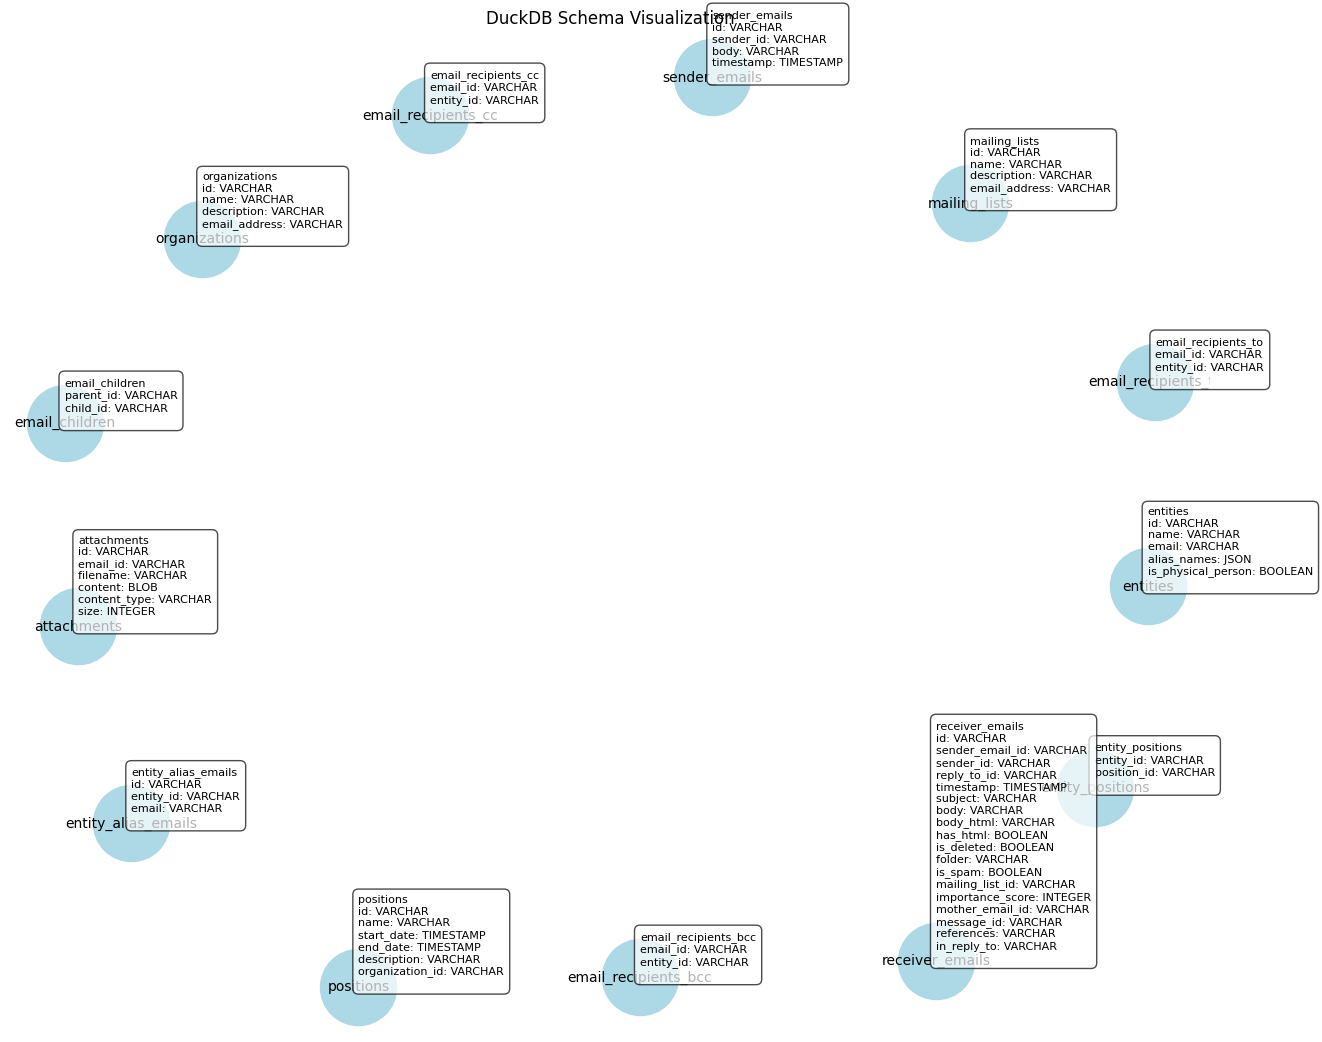

In [ ]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display
import seaborn as sns

# Connect to your DuckDB database
# conn = duckdb.connect('your_database.db')  # or use ':memory:' for in-memory database

# Method 1: Get schema information as pandas DataFrame
def get_schema_as_dataframe():
    # Get all tables
    tables_df = duckdb_conn.execute("""
        SELECT table_schema, table_name
        FROM information_schema.tables
        WHERE table_schema != 'pg_catalog'
    """).df()

    # Get all columns with their data types
    columns_df = duckdb_conn.execute("""
        SELECT
            table_schema,
            table_name,
            column_name,
            data_type,
            is_nullable,
            column_default
        FROM information_schema.columns
        WHERE table_schema != 'pg_catalog'
        ORDER BY table_schema, table_name, ordinal_position
    """).df()

    return tables_df, columns_df

# Method 2: Print schema in a readable format
def print_schema():
    # Get all tables
    tables = duckdb_conn.execute("""
        SELECT table_name
        FROM information_schema.tables
        WHERE table_schema = 'main'
    """).fetchall()

    for table in tables:
        table_name = table[0]
        print(f"\n=== TABLE: {table_name} ===")

        # Get columns for this table
        columns = duckdb_conn.execute(f"""
            DESCRIBE {table_name}
        """).fetchall()

        # Print column information
        for col in columns:
            print(f"{col[0]}: {col[1]}")

# Method 3: Visualize schema using networkx and matplotlib
def visualize_schema():
    # Get tables and their columns
    tables_columns = duckdb_conn.execute("""
        SELECT
            table_name,
            column_name,
            data_type
        FROM information_schema.columns
        WHERE table_schema = 'main'
        ORDER BY table_name, ordinal_position
    """).fetchall()

    # Create a graph
    G = nx.DiGraph()

    # Group by tables
    tables = {}
    for table_name, column_name, data_type in tables_columns:
        if table_name not in tables:
            tables[table_name] = []
        tables[table_name].append((column_name, data_type))

    # Add nodes for tables
    for table_name, columns in tables.items():
        # Create label with table name and columns
        label = f"{table_name}\n"
        for col_name, col_type in columns:
            label += f"{col_name}: {col_type}\n"

        G.add_node(table_name, label=label)

    # Try to find foreign key relationships (this is simplified)
    # In a real scenario, you'd need to query DuckDB's constraints
    for table1 in tables:
        for table2 in tables:
            if table1 != table2:
                for col1_name, _ in tables[table1]:
                    if col1_name == f"{table2}_id":
                        G.add_edge(table1, table2)

    # Draw the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=3000, arrows=True, font_size=10)

    # Add detailed labels
    labels = nx.get_node_attributes(G, 'label')
    text_items = {}
    for node, label in labels.items():
        text_items[node] = plt.annotate(label, xy=pos[node],
                                       xytext=(0, 0),
                                       textcoords="offset points",
                                       bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7),
                                       fontsize=8)

    plt.title("DuckDB Schema Visualization")
    plt.tight_layout()
    plt.show()

# Example usage:
tables_df, columns_df = get_schema_as_dataframe()
# display(tables_df)
# display(columns_df)

# print_schema()

visualize_schema()

In [ ]:
import duckdb
import pandas as pd
from eralchemy2 import render_er
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Float, ForeignKey

# Connect to DuckDB
# conn = duckdb.connect('your_database.db')

# Get table information
tables_info = duckdb_conn.execute("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'main'
""").fetchall()

# Create SQLAlchemy metadata
metadata = MetaData()

# For each table, create a SQLAlchemy Table object
for table_info in tables_info:
    table_name = table_info[0]

    # Get column information
    columns_info = duckdb_conn.execute(f"""
        SELECT
            column_name,
            data_type,
            is_nullable
        FROM information_schema.columns
        WHERE table_schema = 'main' AND table_name = '{table_name}'
    """).fetchall()

    # Create SQLAlchemy columns
    columns = []
    for col_info in columns_info:
        col_name, col_type, is_nullable = col_info

        # Map DuckDB types to SQLAlchemy types (simplified mapping)
        if 'INT' in col_type.upper():
            sa_type = Integer()
        elif 'VARCHAR' in col_type.upper() or 'CHAR' in col_type.upper():
            sa_type = String()
        elif 'FLOAT' in col_type.upper() or 'DOUBLE' in col_type.upper() or 'DECIMAL' in col_type.upper():
            sa_type = Float()
        else:
            sa_type = String()  # Default fallback

        columns.append(Column(col_name, sa_type, nullable=(is_nullable == 'YES')))

    # Create the table
    Table(table_name, metadata, *columns)

# Now render the ER diagram
render_er(metadata, 'duckdb_schema.png')

In [ ]:
import duckdb
import jinja2

# Connect to DuckDB
conn = duckdb.connect('your_database.db')

# Get tables and columns
tables_columns = conn.execute("""
    SELECT
        table_name,
        column_name,
        data_type
    FROM information_schema.columns
    WHERE table_schema = 'main'
    ORDER BY table_name, ordinal_position
""").fetchall()

# Organize data
tables_data = {}
for table_name, column_name, data_type in tables_columns:
    if table_name not in tables_data:
        tables_data[table_name] = []
    tables_data[table_name].append((column_name, data_type))

# Convert to format for template
template_data = []
for table_name, columns in tables_data.items():
    template_data.append({
        'name': table_name,
        'columns': [{'name': col[0], 'type': col[1]} for col in columns]
    })

# Template
template_str = """
<html>
<head>
  <title>DuckDB Schema</title>
  <style>
    body { font-family: Arial, sans-serif; margin: 20px; }
    .table { margin-bottom: 20px; border: 1px solid #ccc; padding: 10px; }
    .table-name { font-weight: bold; font-size: 1.2em; margin-bottom: 10px; }
    .column { margin-left: 20px; }
  </style>
</head>
<body>
  <h1>DuckDB Schema</h1>
  {% for table in tables %}
  <div class="table">
    <div class="table-name">{{ table.name }}</div>
    {% for column in table.columns %}
    <div class="column">{{ column.name }}: {{ column.type }}</div>
    {% endfor %}
  </div>
  {% endfor %}
</body>
</html>
"""

# Render template
template = jinja2.Template(template_str)
html_output = template.render(tables=template_data)

# Save to file
with open('duckdb_schema.html', 'w') as f:
    f.write(html_output)

In [22]:
# duckdb_conn

In [ ]:
SELECT * FROM receiver_emails
WHERE id = '3887d55a-5254-42c4-8a6a-d0961e33aa86';


-- Vérifiez les pièces jointes
SELECT * FROM attachments
WHERE email_id = '3887d55a-5254-42c4-8a6a-d0961e33aa86';

-- Vérifiez les destinataires
SELECT * FROM email_recipients_to
WHERE email_id = '3887d55a-5254-42c4-8a6a-d0961e33aa86';

SELECT * FROM email_recipients_cc
WHERE email_id = '3887d55a-5254-42c4-8a6a-d0961e33aa86';

SELECT * FROM email_recipients_bcc
WHERE email_id = '3887d55a-5254-42c4-8a6a-d0961e33aa86';


-- Emails qui devraient avoir une relation parent mais n'en ont pas
SELECT * FROM receiver_emails
WHERE in_reply_to IS NOT NULL
AND mother_email_id IS NULL;

-- Emails qui devraient être dans la table email_children mais n'y sont pas
SELECT r.id FROM receiver_emails r
WHERE r.mother_email_id IS NOT NULL
AND NOT EXISTS (
    SELECT 1 FROM email_children c
    WHERE c.parent_id = r.mother_email_id AND c.child_id = r.id
);


In [ ]:
# setup_database()